In [1]:
# clone the yolov5 repo
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Download dataset from robolflow.

API generateing - https://app.roboflow.com/computervision-xjlpx/settings/api
Add your Roboflow API key below to download the  dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.## Download a Dataset
API genera

In [3]:
!pip install -q roboflow

In [4]:
#download data using api from roboflow.

from roboflow import Roboflow
rf = Roboflow(api_key="V8a4ex2pQjejvNIZZ0YC")
project = rf.workspace("my-workspace-c63k0").project("construction-safety-n0gkb")
version = project.version(2)
dataset = version.download("yolov5")



loading Roboflow workspace...
loading Roboflow project...


In [5]:
! pwd.  # current working directroy

/bin/bash: line 1: pwd.: command not found


In [6]:
data_location = dataset.location #dataset location getting.

Define Model Configuration and Architecture
We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.





In [7]:
# define number of classes based on YAML
import yaml

# Path to your YAML file
yaml_file_path = '/content/yolov5/construction-safety-2/data.yaml'

# Load the YAML file
with open(yaml_file_path, 'r') as stream:
    data = yaml.safe_load(stream)

# Extract the number of classes and class names
num_classes = data['nc']
class_names = data['names']

# Print the number of classes and class names
print(f"Number of classes: {num_classes}")
print("Class names:")
for name in class_names:
    print(f"- {name}")

Number of classes: 26
Class names:
- 0
- 1
- 2
- 3
- 4
- Glass
- Gloves
- Goggles
- Helmet
- No-Helmet
- No-Vest
- Person
- Reflective-Vest
- Safety-Boot
- Safety-Vest
- Vest
- Yelek
- helmet
- no helmet
- no vest
- no_helmet
- no_vest
- protective_suit
- safety vest - v1 2023-11-19 5-12pm
- vest
- worker


In [8]:
#this is the model configuration we will use for our project
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector
Next, we'll fire off training!
Here, we are able to pass a number of arguments:

img: define input image size

batch: determine batch size

epochs: define the number of training epochs. (Note: often, 3000+ are common here!)

data: set the path to our yaml file

cfg: specify our model configuration

weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
name: result names

nosave: only save the final checkpoint

cache: cache images for faster training

In [11]:
# # train yolov5s on custom data for 200 epochs
# # time its performance
# %%time
# %cd /content/yolov5/
# !python train.py --img 416 --batch 32 --epochs 50 --data /content/yolov5/construction-safety-2/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache




%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 100 --data /content/yolov5/construction-safety-2/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache --patience 20 --delta 0.001


/content/yolov5
2024-05-17 05:09:58.959203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 05:09:58.959248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 05:09:58.960599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP] [--epochs EPOCHS]
                [--batch-size BATCH_SIZE] [--imgsz IMGSZ] [--rect] [--resume [RESUME]] [--nosave]
                [--noval] [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--evolve_population EVOLVE_POPULATION] [--resume_evolve RESUME

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

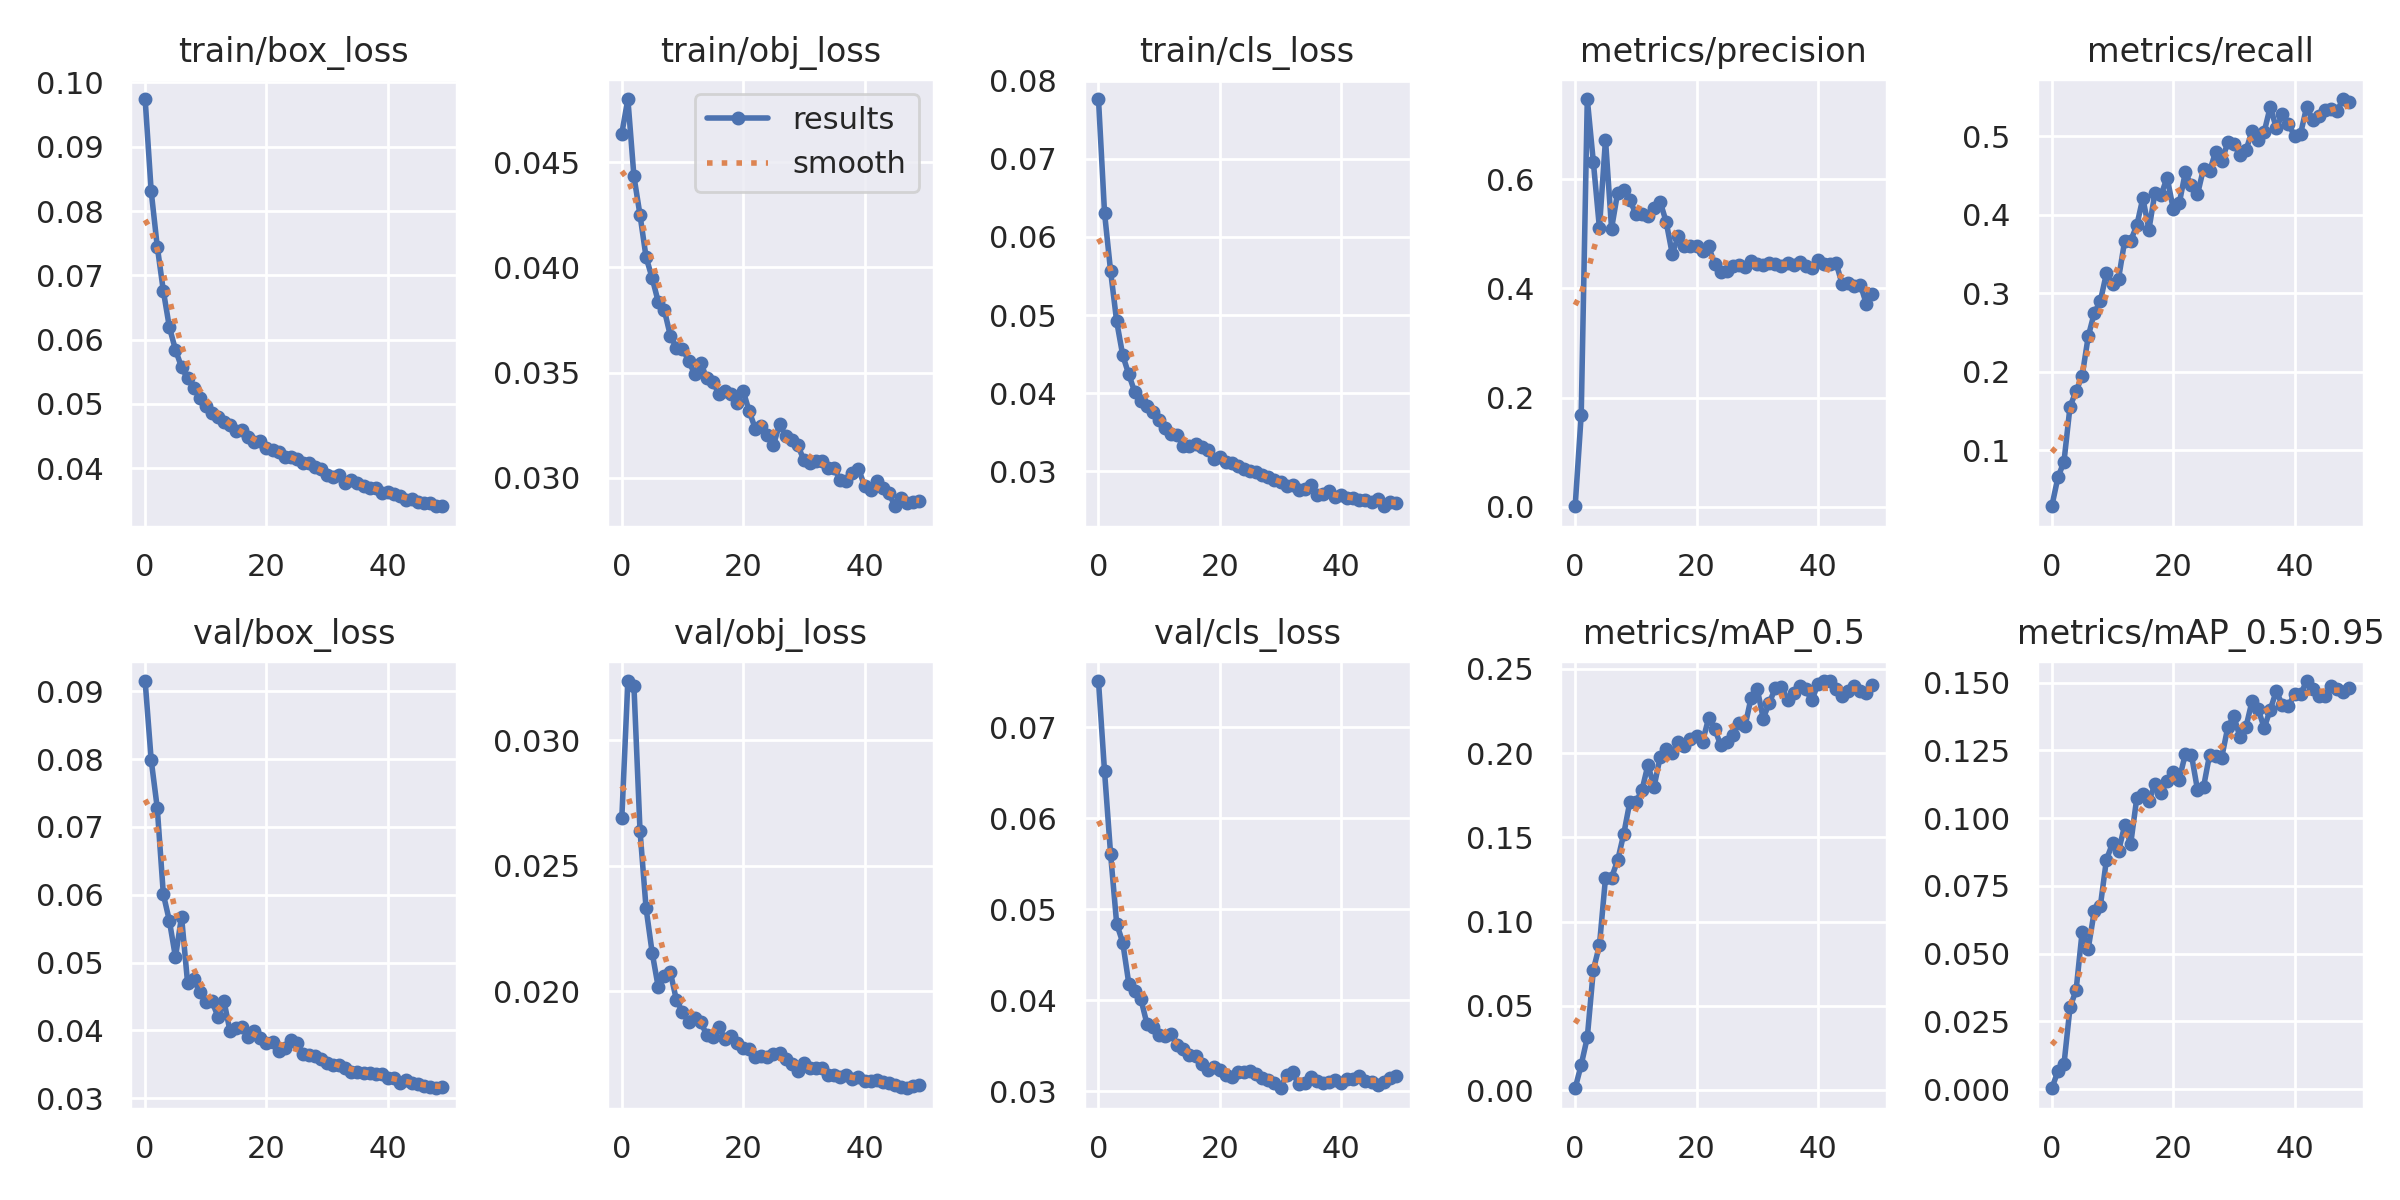

In [12]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

# Visualize Our Training Data with Labels
After training starts, view train*.jpg images to see training images, labels and augmentation effects.

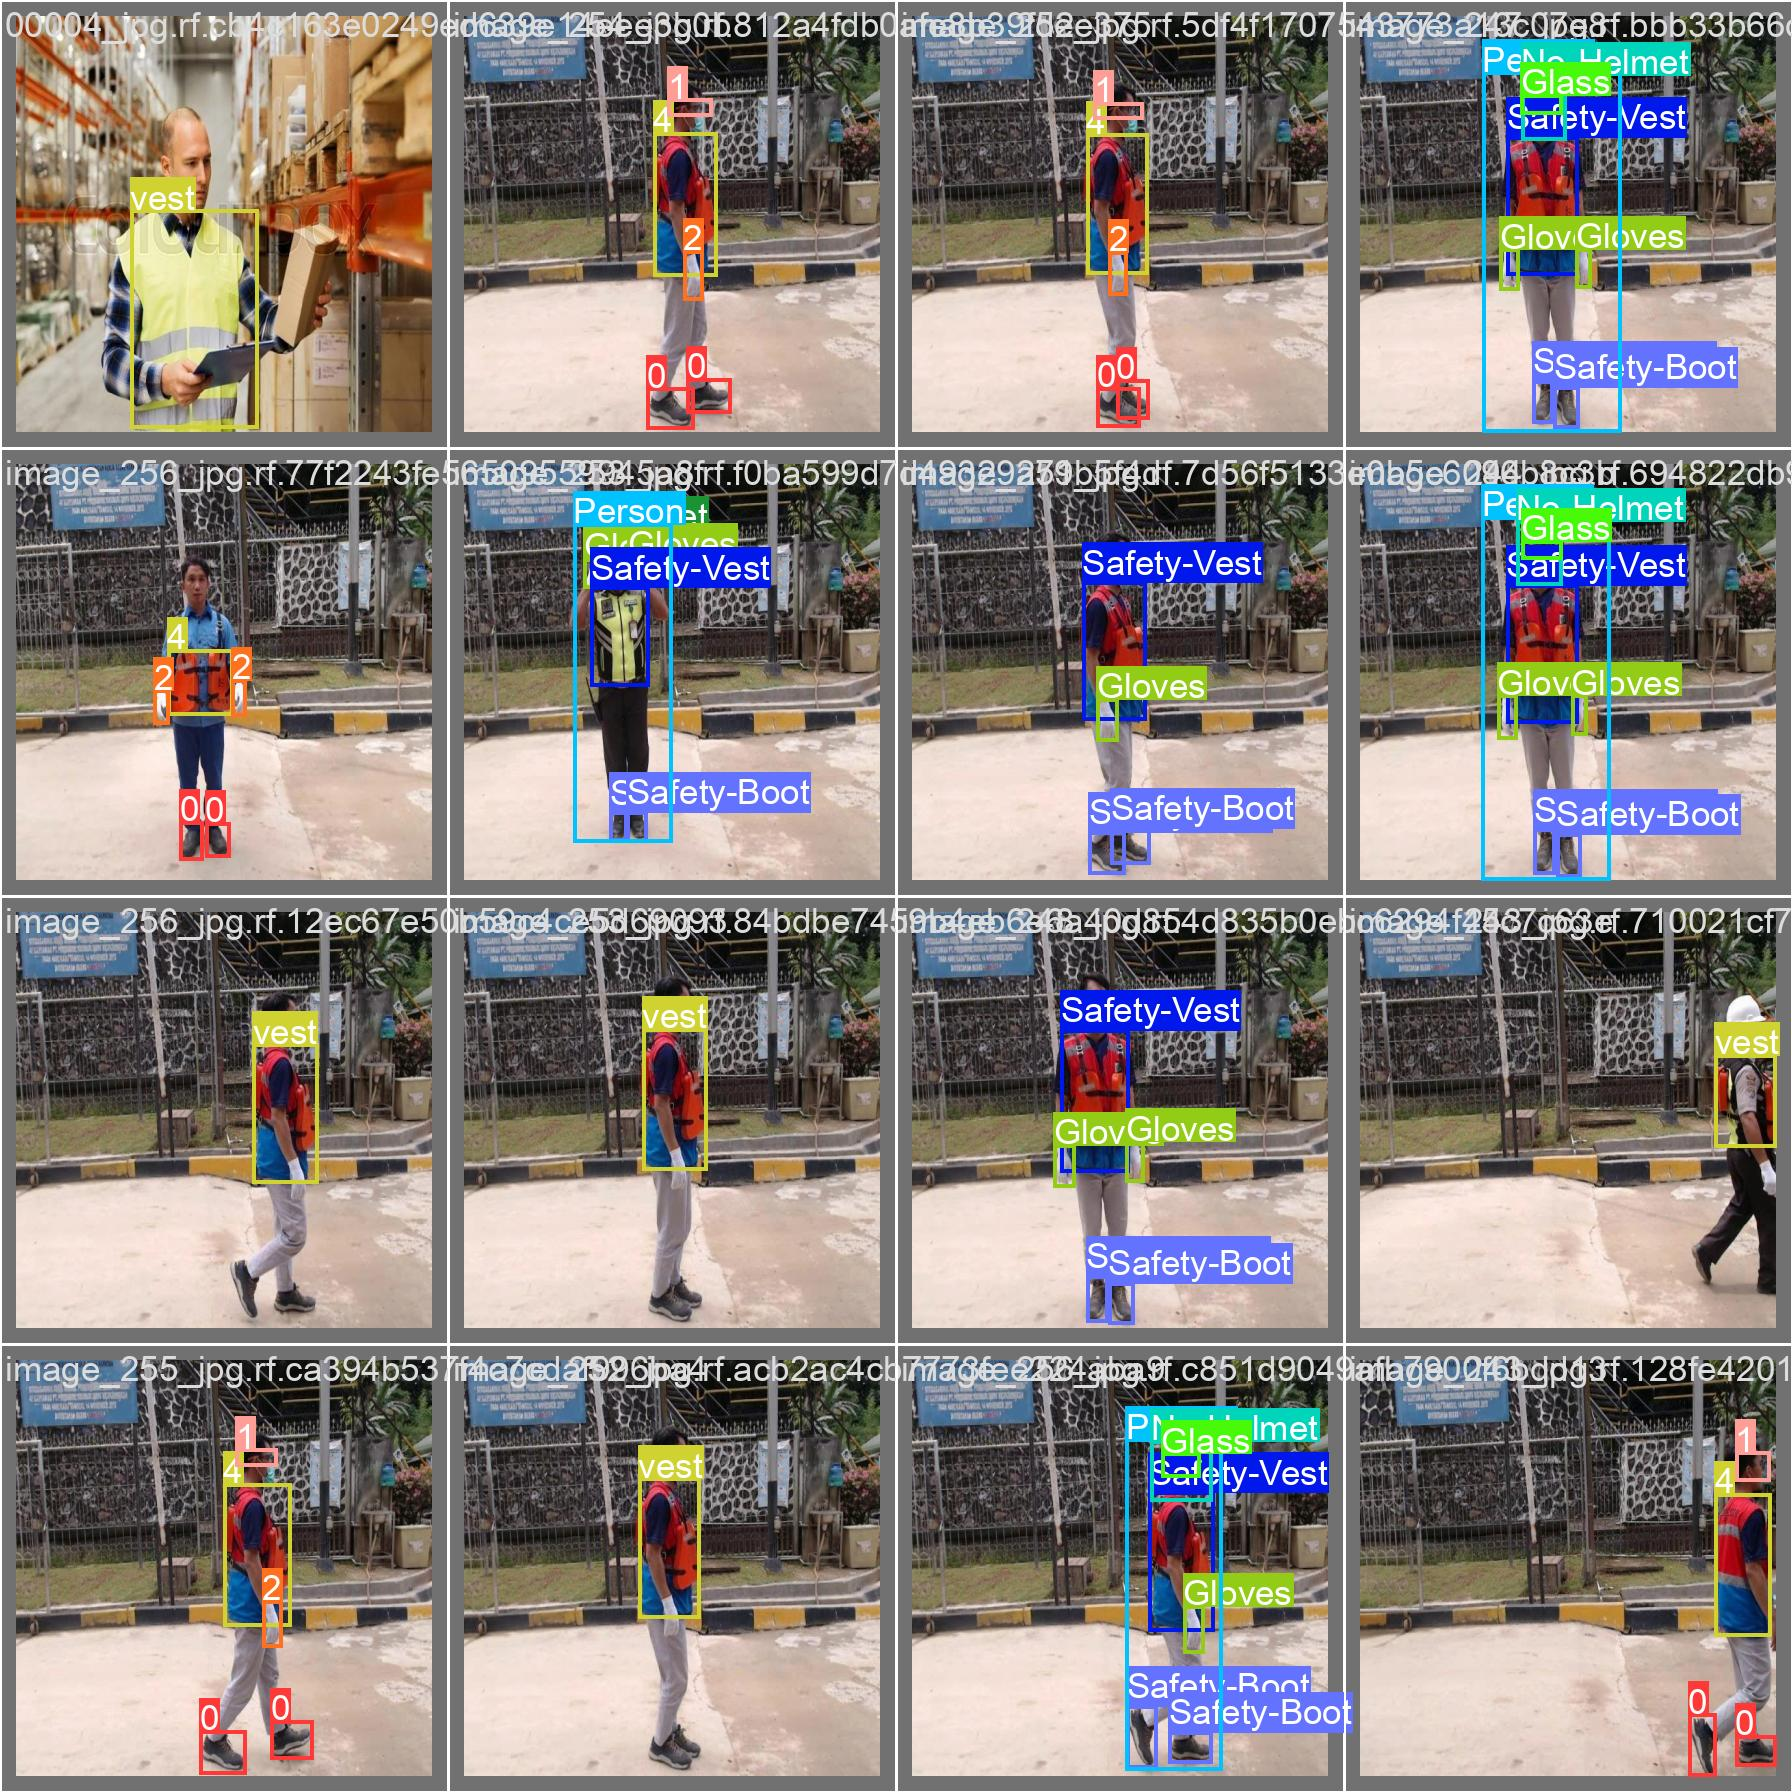

In [13]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


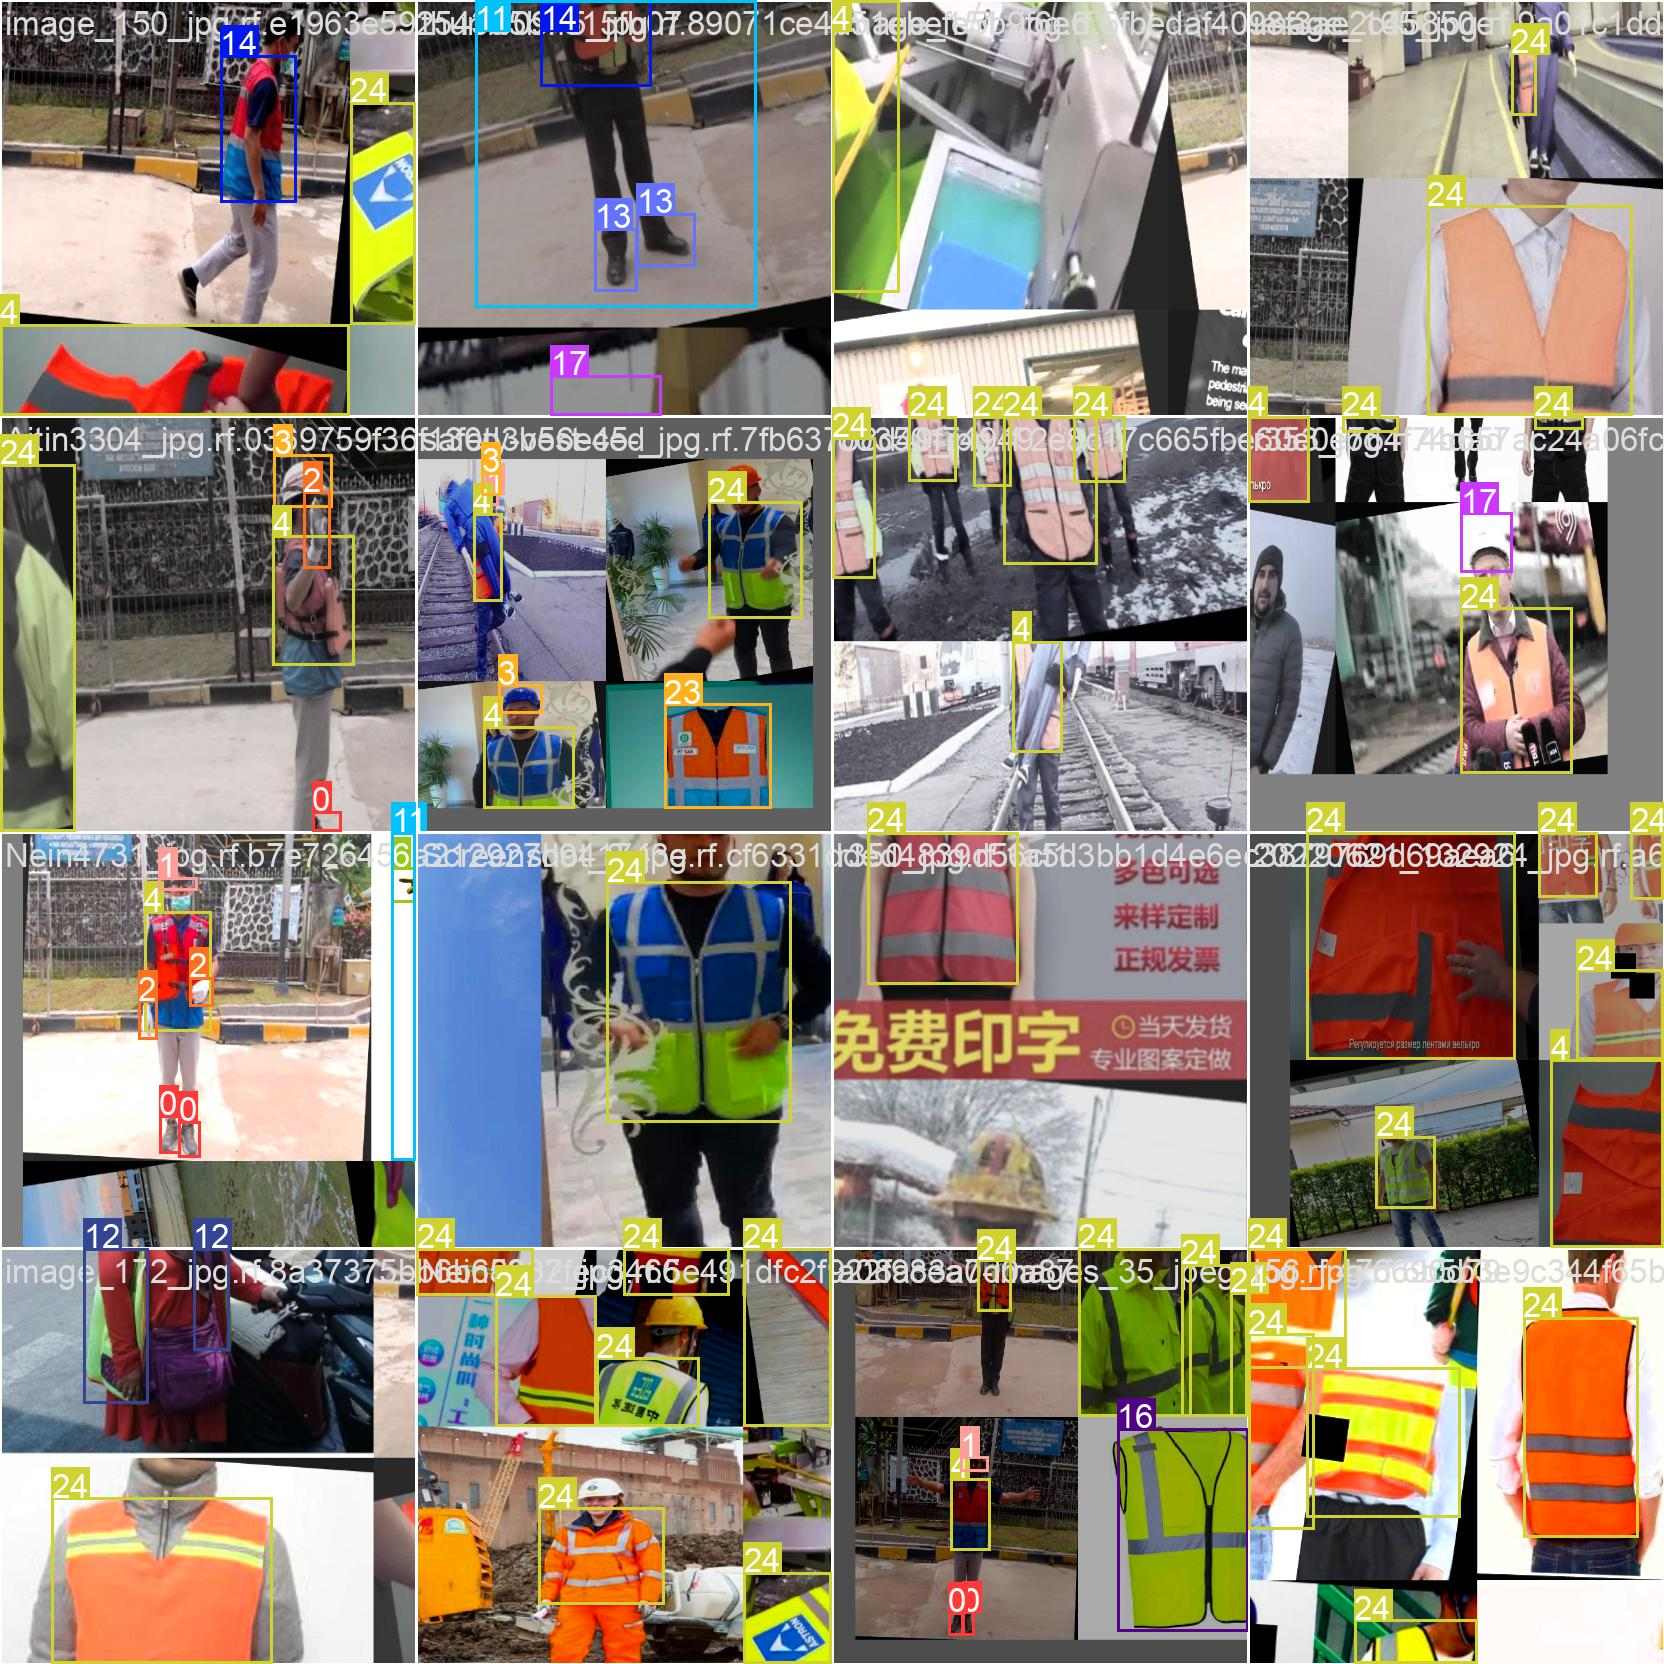

In [14]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

# Run Inference With Trained Weights
Next, we can run inference with a pretrained checkpoint on all images in the test/images folder to understand how our model performs on our test set.

In [15]:
# trained weights are saved by default in our weights folder
%ls runs/

detect/  train/


In [16]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [17]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/construction-safety-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/construction-safety-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7313943 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/209 /content/yolov5/construction-safety-2/test/images/00000383_jpg.rf.6615be7ef4374a733dca2de01a772336.jpg: 416x416 2 vests, 7.7ms
image 2/209 /content/yolov5/construction-safety-2/test/images/00004_jpg.rf.b2d61498f359611ff8d

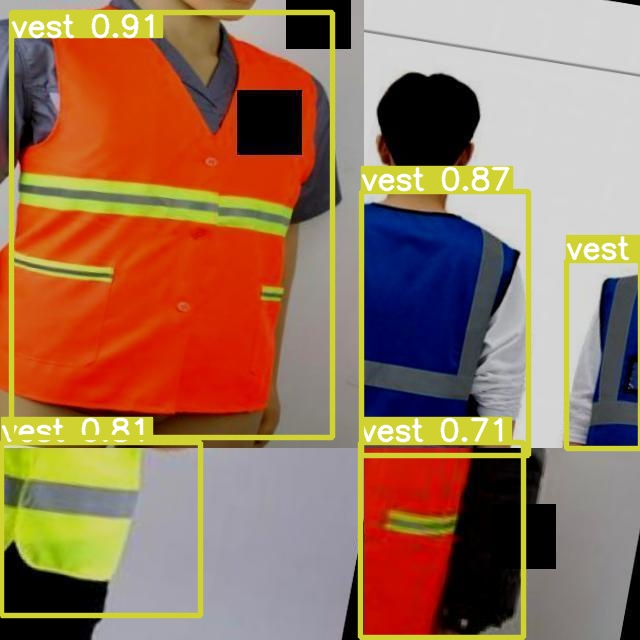

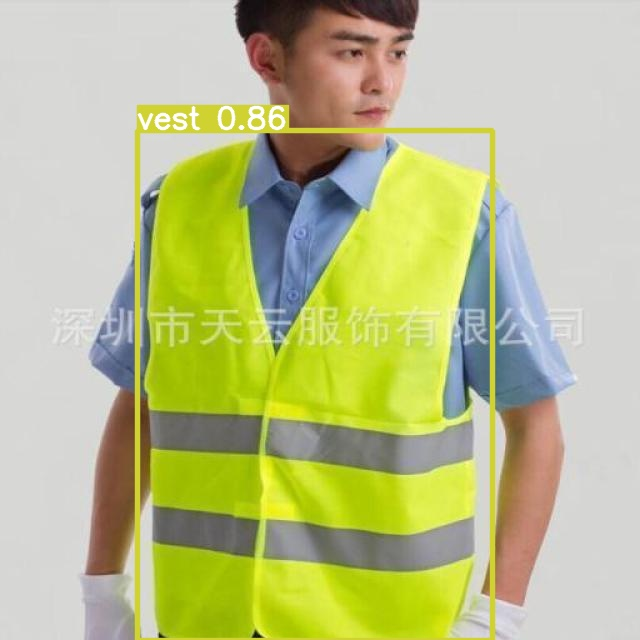

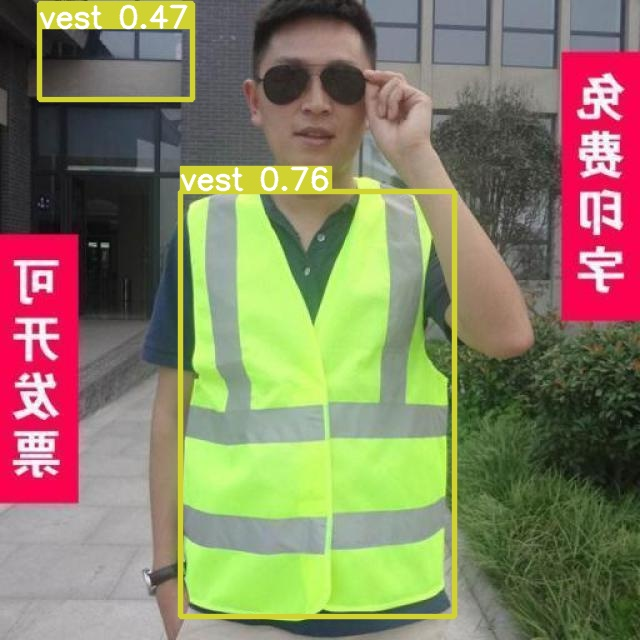

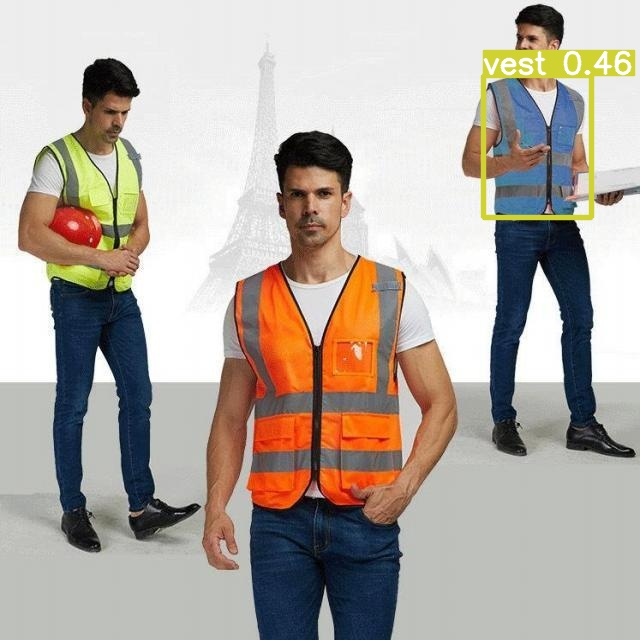

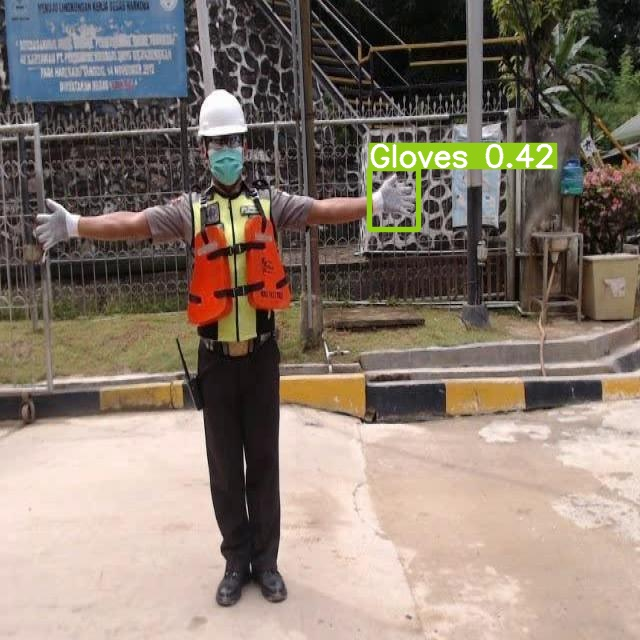

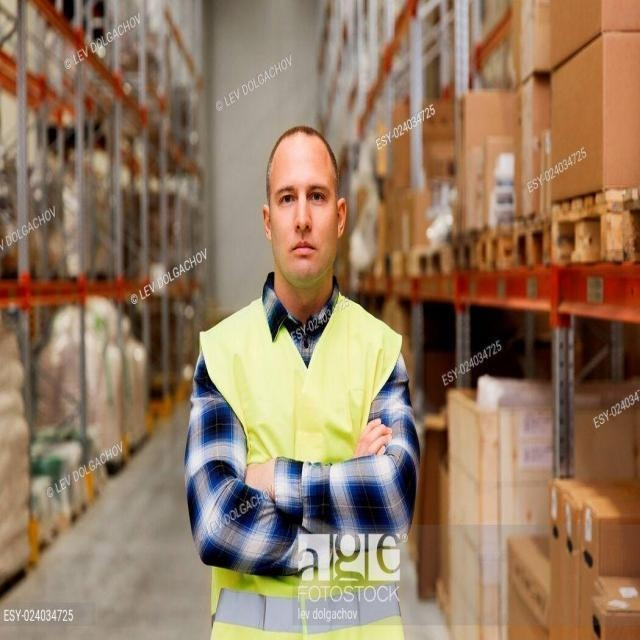

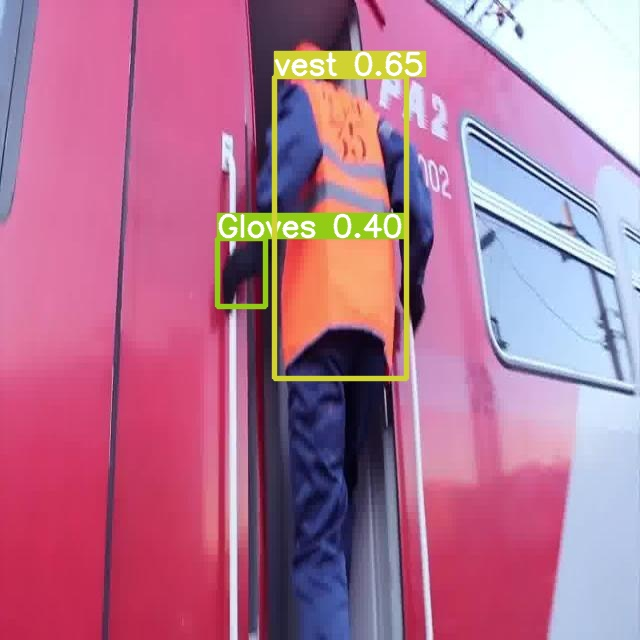

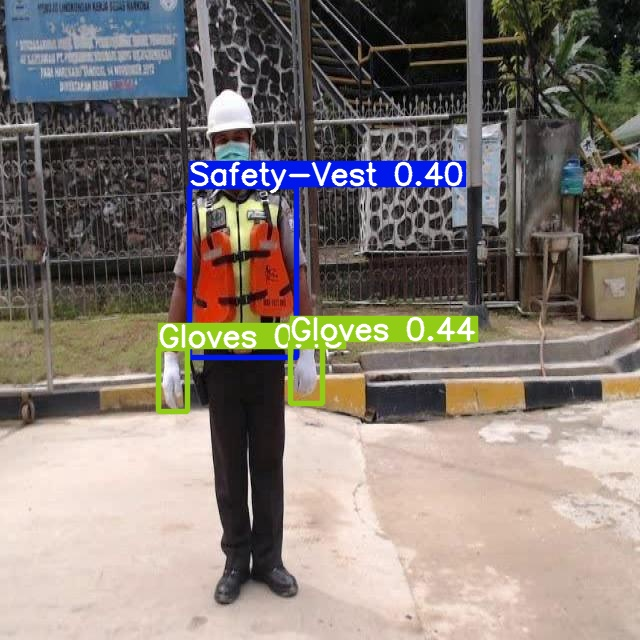

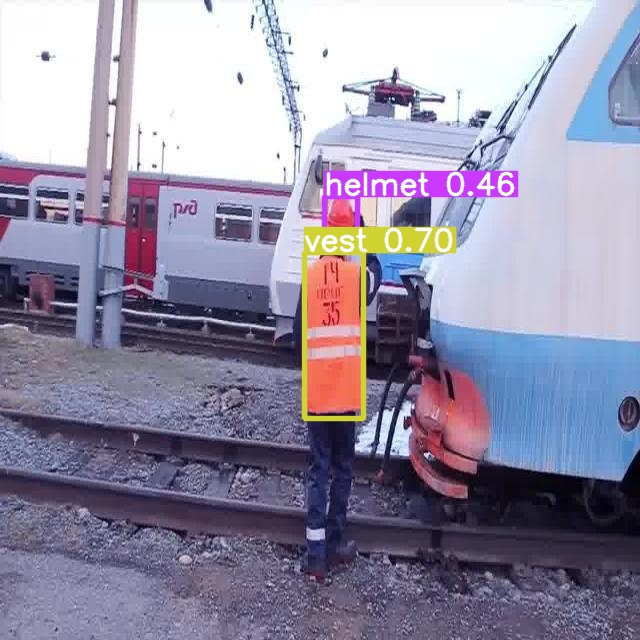

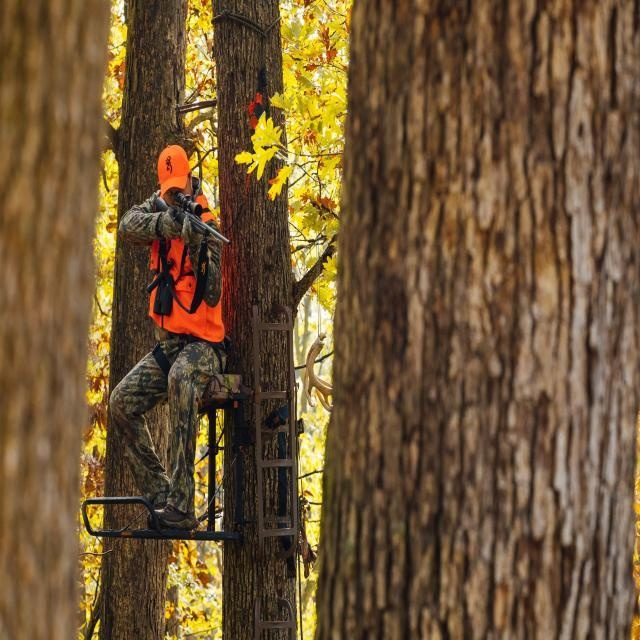

In [18]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))